## Delivery Duration Prediction

The main goal of this analysis is to predict the delivery order duration for the customers. In order to do so, I'll use the DoorDash dataset from the Strata Scratch website. The dataset contains 197428 observations and 16 variables. The variables are as follows:
<table>
    <tr>
        <td><b>Feature</b></td>
        <td><b>Description</b></td>
    </tr>
    <tr>
        <td>market_id</td>
        <td>A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id</td>
    </tr>
    <tr>
        <td>created_at</td>
        <td>Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)</td>
    </tr>
    <tr>
        <td>actual_delivery_time</td>
        <td>Timestamp in UTC when the order was delivered to the consumer</td>
    </tr>
    <tr>
        <td>store_id</td>
        <td>An id representing the restaurant the order was submitted for</td>
    </tr>
    <tr>
        <td>store_primary_category</td>
        <td>Cuisine category of the restaurant, e.g., italian, asian</td>
    </tr>
    <tr>
        <td>order_protocol</td>
        <td>A store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol</td>
    </tr>
    <tr>
        <td>total_items</td>
        <td>Total number of items in the order</td>
    </tr>
    <tr>
        <td>subtotal</td>
        <td>Total value of the order submitted (in cents)</td>
    </tr>
    <tr>
        <td>num_distinct_items</td>
        <td>Number of distinct items included in the order</td>
    </tr>
    <tr>
        <td>min_item_price</td>
        <td>Price of the item with the least cost in the order (in cents)</td>
    </tr>
    <tr>
        <td>max_item_price</td>
        <td>Price of the item with the highest cost in the order (in cents)</td>
    </tr>
    <tr>
        <td>total_onshift_dashers</td>
        <td>Number of available dashers who are within 10 miles of the store at the time of order creation</td>
    </tr>
    <tr>
        <td>total_busy_dashers</td>
        <td>Subset of above total_onshift_dashers who are currently working on an order</td>
    </tr>
    <tr>
        <td>total_outstanding_orders</td>
        <td>Number of orders within 10 miles of this order that are currently being processed</td>
    </tr>
    <tr>
        <td>estimated_order_place_duration</td>
        <td>Estimated time for the restaurant to receive the order from DoorDash (in seconds)</td>
    </tr>
    <tr>
        <td>estimated_store_to_consumer_driving_duration</td>
        <td>Estimated travel time between store and consumer (in seconds)</td>
    </tr>
</table>

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data overview

In [2]:
data = pd.read_csv('data/historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

By looking at this information we can conclude that the data has missing values which should be filled

### Handling missing values

In [4]:
data.dropna(subset=['actual_delivery_time'], axis=0, inplace=True)
data['estimated_store_to_consumer_driving_duration'] = data['estimated_store_to_consumer_driving_duration'].fillna(data['estimated_store_to_consumer_driving_duration'].median())
data['market_id'] = data['market_id'].fillna(data['market_id'].mode()[0])
data['store_primary_category'] = data['store_primary_category'].replace(np.nan, data['store_primary_category'].mode()[0])
data['order_protocol'] = data['order_protocol'].replace(np.nan, data['order_protocol'].mode()[0])
data['total_onshift_dashers'] = data['total_onshift_dashers'].replace(np.nan, data['total_onshift_dashers'].mode()[0])
data['total_busy_dashers'] = data['total_busy_dashers'].replace(np.nan, data['total_busy_dashers'].mode()[0])
data['total_outstanding_orders'] = data['total_outstanding_orders'].replace(np.nan, data['total_outstanding_orders'].mode()[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     197421 non-null  float64
 1   created_at                                    197421 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197421 non-null  int64  
 4   store_primary_category                        197421 non-null  object 
 5   order_protocol                                197421 non-null  float64
 6   total_items                                   197421 non-null  int64  
 7   subtotal                                      197421 non-null  int64  
 8   num_distinct_items                            197421 non-null  int64  
 9   min_item_price                                197421 

### Converting data to the correct types and creating a target variable

In [5]:
data[['created_at', 'actual_delivery_time']] = data[['created_at', 'actual_delivery_time']].apply(pd.to_datetime)

In [7]:
data['delivery_time'] = (data.actual_delivery_time - data.created_at).dt.seconds
data.delivery_time

0         3779
1         4024
2         1781
3         3075
4         2390
          ... 
197423    3907
197424    3383
197425    3008
197426    3907
197427    2228
Name: delivery_time, Length: 197421, dtype: int32

### Exploratory data analysis

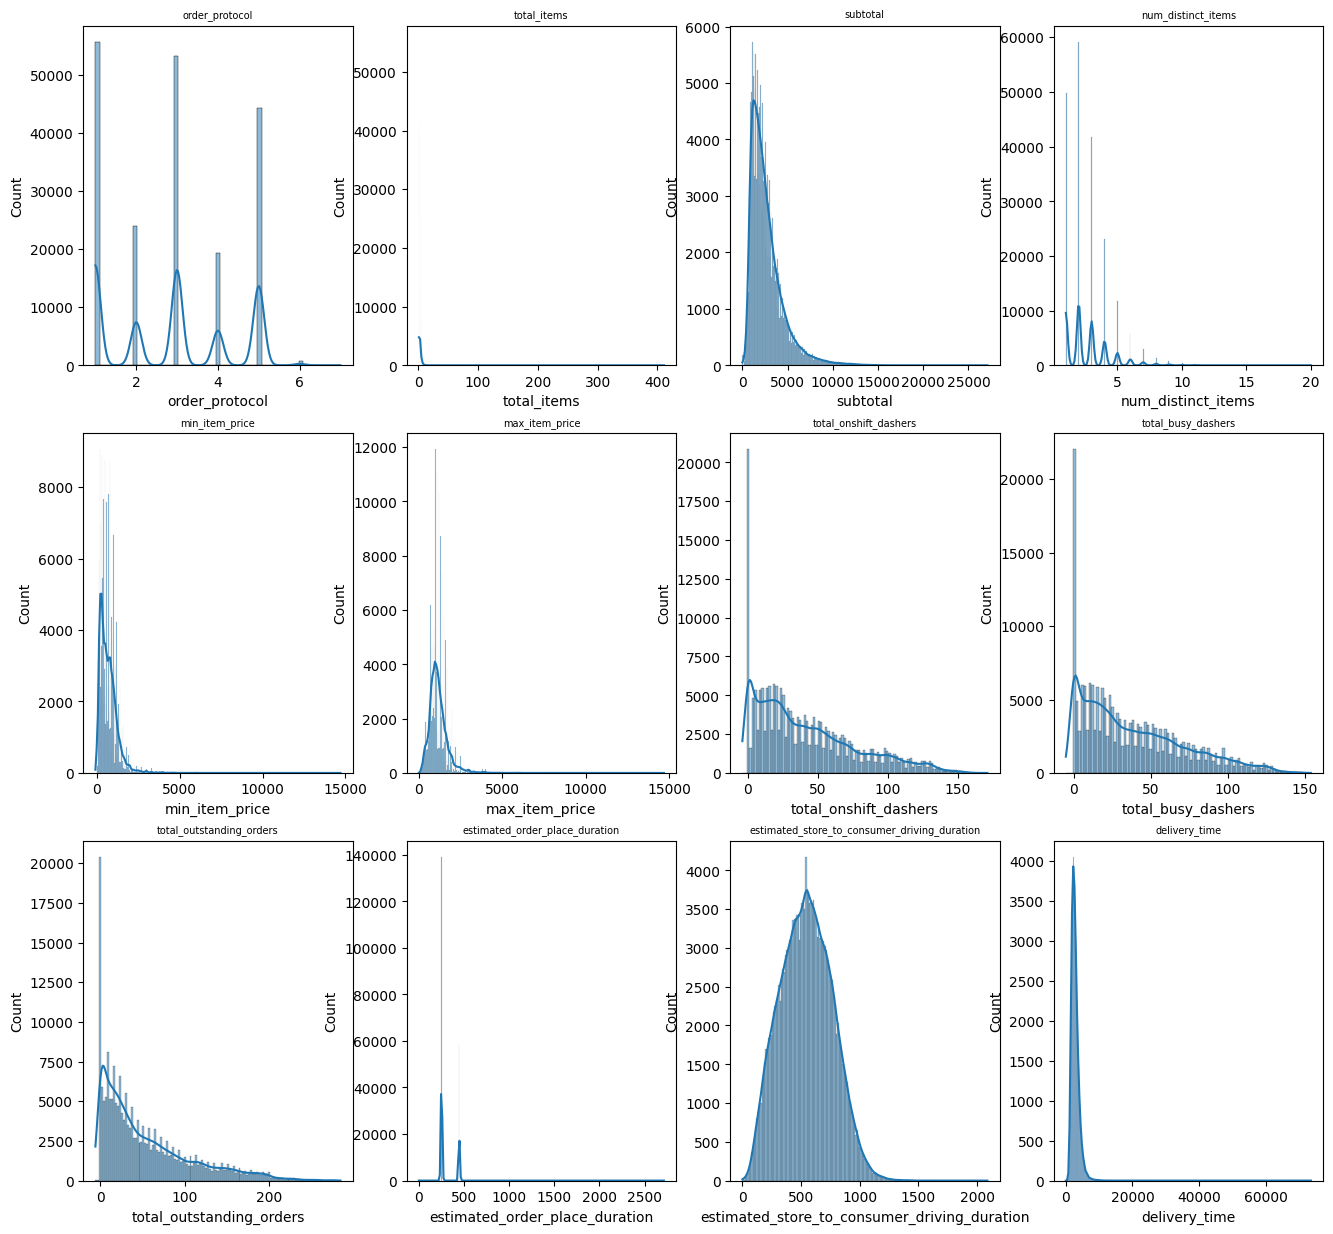

In [13]:
plt.figure(figsize=(16,15))
for i, f in enumerate(data.columns[5:], start=1):
    plt.subplot(3, 4, i)
    sns.histplot(data[f], kde=True)
    plt.title(f, fontsize=7)

From these plots we can clearly see some number of outliers in the data.

In [14]:
data.describe()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time
count,197421.000000,197421,197421,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000
mean,2.973807,2015-02-04 21:59:55.091540480,2015-02-04 22:48:23.348914176,3530.581397,2.872871,3.196367,2682.326379,2.670780,686.224596,1159.590444,41.116026,38.300672,53.266431,308.560244,545.353473,2862.304816
min,1.000000,2014-10-19 05:24:15,2015-01-21 15:58:11,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,101.000000
25%,2.000000,2015-01-29 02:32:38,2015-01-29 03:22:29,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,13.000000,11.000000,12.000000,251.000000,383.000000,2104.000000
50%,3.000000,2015-02-05 03:29:06,2015-02-05 04:40:41,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,32.000000,30.000000,35.000000,251.000000,544.000000,2660.000000
75%,4.000000,2015-02-12 01:39:14,2015-02-12 02:25:26,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,62.000000,59.000000,80.000000,446.000000,702.000000,3381.000000
max,6.000000,2015-02-18 06:00:44,2015-02-19 22:45:31,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,73282.000000
std,1.522628,NaN,NaN,2053.493429,1.505892,2.666552,1823.106256,1.630261,522.044061,558.416236,35.293070,32.861493,52.908906,90.139725,219.061573,1180.916229


The statistical description table shows that the data definitely has outliers in the `total_item`, `subtotal`, `num_distinct_items`, `(min/max)_item_price`, `total_onshift_dashers` and the rest of the columns

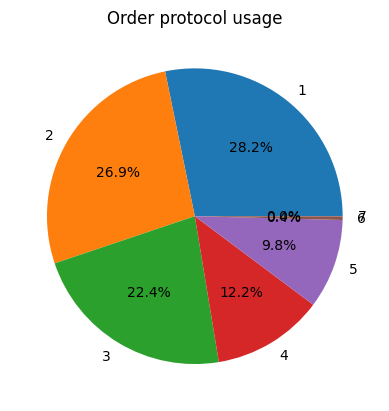

In [21]:
plt.title('Order protocol usage')
plt.pie(data.order_protocol.value_counts(), labels=list(range(1, 8)), autopct='%1.1f%%')
plt.show()

<Axes: xlabel='order_protocol', ylabel='delivery_time'>

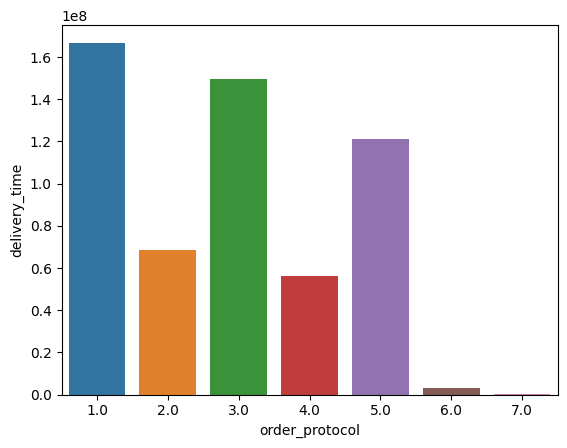

In [28]:
sns.barplot(x=data.groupby('order_protocol').delivery_time.sum().index, y=data.groupby('order_protocol').delivery_time.sum())

From the graphs above I can say that the order protocols 1, 2 and 3 are the most popular among the customers and 1 and 3 have the long total delivery duration. Protocols 6 and 7 are almost never used.

<Axes: title={'center': 'Min vs Max item prices in the orders'}>

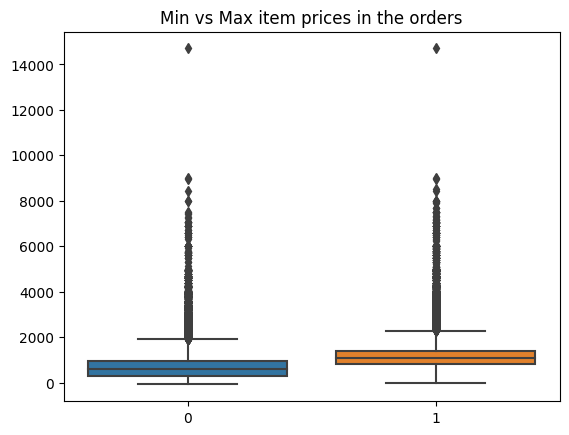

In [34]:
plt.title('Min vs Max item prices in the orders')
sns.boxplot(data=[data['min_item_price'], data['max_item_price']])

<Axes: title={'center': 'Total vs busy dashers distributions'}>

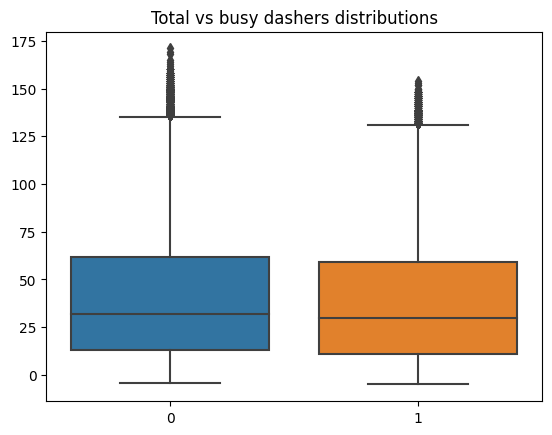

In [41]:
plt.title('Total vs busy dashers distributions')
sns.boxplot(data=[data['total_onshift_dashers'], data['total_busy_dashers']])

C:\Users\Артур\AppData\Local\Temp\ipykernel_2580\4037216932.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(estimated_time_to_consumer, hist=False, color='b', label='Estimated duration')
C:\Users\Артур\AppData\Local\Temp\ipykernel_2580\4037216932.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

<Axes: xlabel='delivery_time', ylabel='Density'>

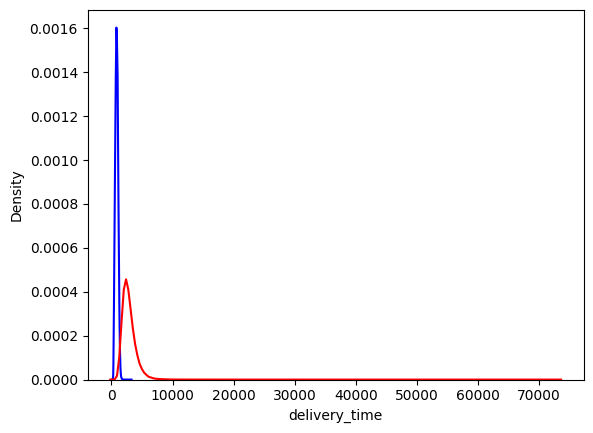

In [38]:
estimated_time_to_consumer = data['estimated_order_place_duration'] + data['estimated_store_to_consumer_driving_duration']
ax = sns.distplot(estimated_time_to_consumer, hist=False, color='b', label='Estimated duration')
sns.distplot(data['delivery_time'], hist=False, color='r', label='Actual value', ax=ax)

Standart company's estimators perform badly because they don't count the time spent on the order preparation. This is why this task requires you to build a model on the historical data.

#### New feature extraction

In [42]:
def define_day_parts(time):
    time = time.hour
    if time > 7 and time <= 12:
        return 'morning'
    elif time > 12 and time <= 17:
        return 'afternoon'
    elif time > 17 and time <= 22:
        return 'evening'
    else:
        return 'night'

data['order_creation_time'] = data.created_at.apply(define_day_parts)
data.head(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time,order_creation_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779,evening
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024,evening
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,american,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781,evening
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,american,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075,evening
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,american,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390,night


In [43]:
from collections import Counter

Counter(data['order_creation_time'])

Counter({'night': 136833, 'evening': 54486, 'afternoon': 6100, 'morning': 2})

d:\Coding\DataScience\Projects\DeliveryTimePrediction\env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


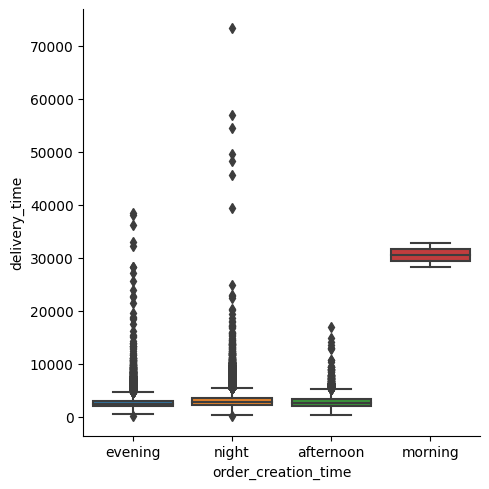

In [44]:
sns.catplot(data=data, x='order_creation_time', y='delivery_time', kind='box')

From the graph above I can say that the created categorical variable doesn't show any significant differences in the target variable.The only one category that could possibly be considered this way is, a morning category, but we have only two samples of it in the whole dataset, which means that it could be an outlier.

<Axes: xlabel='order_creation_time', ylabel='count'>

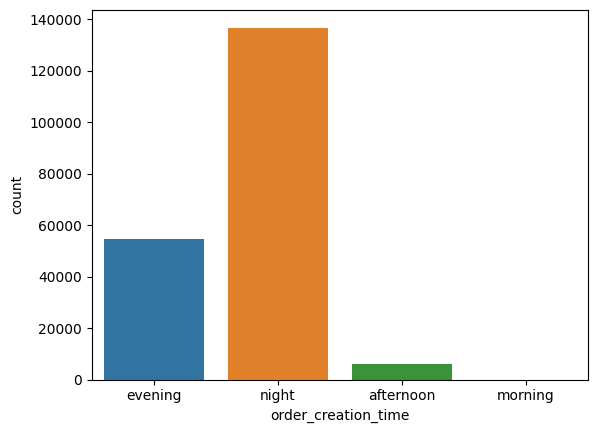

In [12]:
sns.countplot(x=data.order_creation_time)

Dataset mostly consists of orders that were taken in the night

### Getting the additional features through other feature extractions

In [45]:
data['percernt_of_busy_dashers'] = data.total_busy_dashers / data.total_onshift_dashers

In [46]:
data['percernt_of_busy_dashers'].describe()

count    1.775830e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: percernt_of_busy_dashers, dtype: float64

We have a problem with infinite values because of dividing by zero in some cases, so let's get rid of these values.

In [47]:
data['percernt_of_busy_dashers'].replace([np.inf, -np.inf], np.NAN, inplace=True)
data.dropna(inplace=True)

In [48]:
data['percernt_of_busy_dashers'].describe()

count    177544.000000
mean          0.949781
std           0.406191
min         -13.000000
25%           0.826859
50%           0.962264
75%           1.000000
max          31.000000
Name: percernt_of_busy_dashers, dtype: float64

Now that looks normal.

The total time that restaurants need to take to bring the order to the client is the time to get and process the order, then to prepare the order for the consumer and the drive duration to the consumer's home. Our dataset has all of these variables except the order preparation duration, which means that we can create one variable which will represent the non-preparation duration to deliver the order.

In [49]:
data['time_without_preparation'] = data['estimated_order_place_duration'] + data['estimated_store_to_consumer_driving_duration']

In [50]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time,order_creation_time,percernt_of_busy_dashers,time_without_preparation
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779,evening,0.424242,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024,evening,2.000000,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,american,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781,evening,0.000000,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,american,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075,evening,1.000000,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,american,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390,night,1.000000,1096.0


### Variable encoding to prepare the dataset for modeling

In [55]:
data.store_id.nunique()

5613

Here OneHotEncoder will be bad, because it will add new 5613 features.

In [52]:
data.market_id.nunique()

6

In [53]:
data.order_protocol.nunique()

7

In [54]:
data.store_primary_category.nunique()

73

In other cases, OneHotEncoder seems like a good option, so I will use it!

In [56]:
market_id_dummies = pd.get_dummies(data.market_id, prefix='market_id_', dtype='float32')
order_protocol_dummies = pd.get_dummies(data.order_protocol, prefix='order_protocol_', dtype='float32')
store_primary_category_dummies = pd.get_dummies(data.store_primary_category, prefix='store_primary_category_', dtype='float32')
order_creation_dummies = pd.get_dummies(data.order_creation_time, prefix='order_creation_', dtype='float32')

Now let's create the training dataframe with all of these encoded features, deleting the useless.

In [57]:
train_df = data.drop(['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'order_creation_time'], axis=1).astype('float32')
train_df = pd.concat([train_df, market_id_dummies, order_protocol_dummies, store_primary_category_dummies, order_creation_dummies], axis=1)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_primary_category__sushi,store_primary_category__tapas,store_primary_category__thai,store_primary_category__turkish,store_primary_category__vegan,store_primary_category__vegetarian,store_primary_category__vietnamese,order_creation__afternoon,order_creation__evening,order_creation__night
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [58]:
train_df.shape

(177544, 102)

Shape became smaller on the 0-axis because of infinites deleted in the 'percernt_of_busy_dashers' column.

### Handling the outliers in the dataset

In [59]:
from copy import deepcopy

def delete_outliers(data, feature_with_outliers):
    dataframe = deepcopy(data)
    mean = dataframe[feature_with_outliers].mean()
    std = dataframe[feature_with_outliers].std()
    dataframe['outlier'] = np.abs(dataframe[feature_with_outliers] - mean) > 3*std
    dataframe = dataframe[dataframe['outlier'] == False]
    dataframe.drop('outlier', axis=1, inplace=True)
    return dataframe

In [60]:
data_without_outliers = train_df.copy(deep=True)
cols_with_outliers = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_time',
       'percernt_of_busy_dashers', 'time_without_preparation']
for col in cols_with_outliers:
    data_without_outliers = delete_outliers(data_without_outliers, col)

In [61]:
len(data_without_outliers)

159518

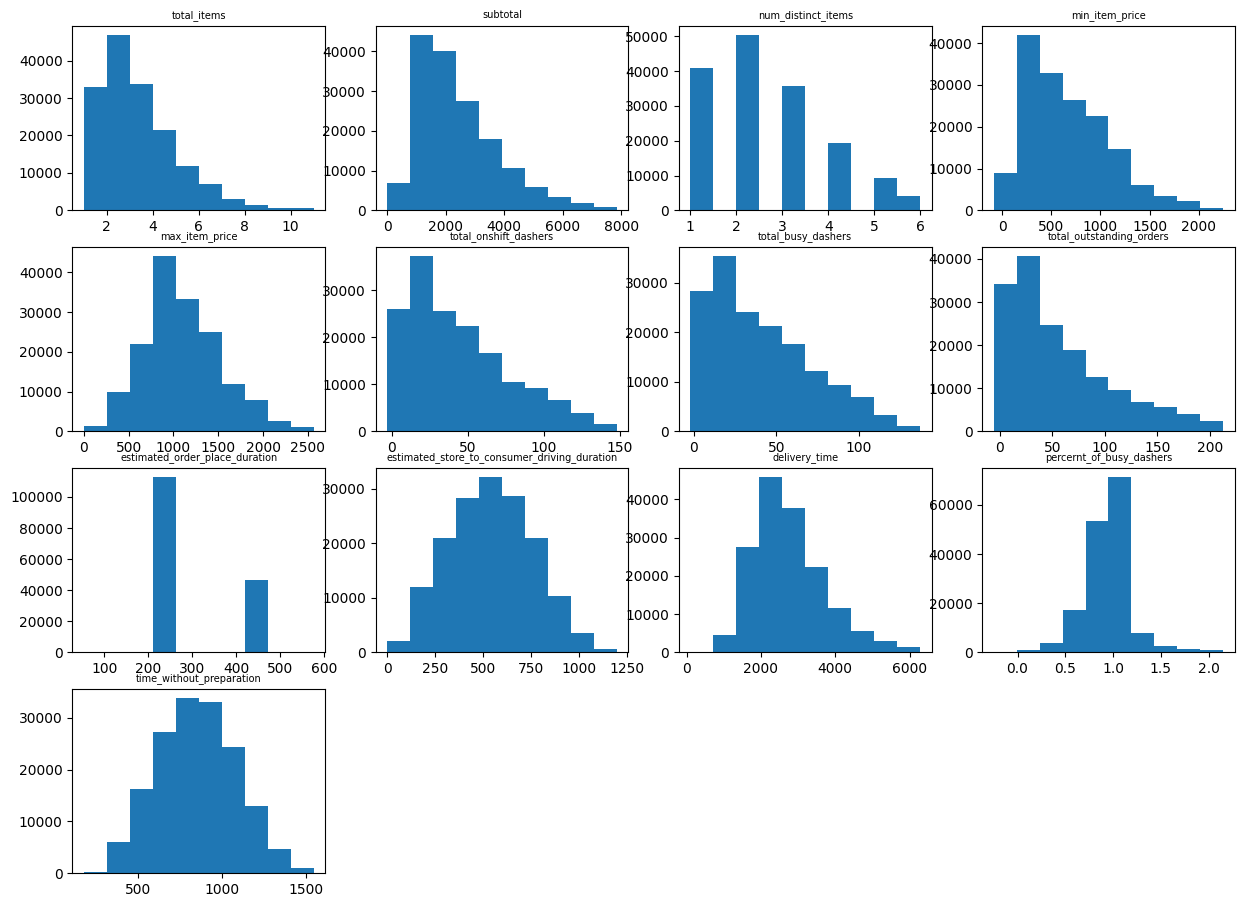

In [62]:
plt.figure(figsize=(15,11))
for i, f in enumerate(data_without_outliers.columns[:13], start=1):
    plt.subplot(4, 4, i)
    plt.hist(data_without_outliers[f])
    plt.title(f, fontsize=7)

Looks like we solved the problem with outliers because distribution hists become more beautiful

### Dealing with collinearity problem

Some features may have a big correlation with each other which will worst model's performance, we need to find and delete those ones or apply some new feature engineering techniques to replace them with other features.

In [32]:
train_df = data_without_outliers.copy(deep=True)

In [33]:
corrs = train_df.corr()

In [34]:
def get_high_correlation_pairs(corrs):
    high_corelations = pd.DataFrame({'Variable_1': [], 'Variable_2': [], 'Correlation': []})
    for var1 in corrs.columns:
        for var2 in corrs.columns:
            if var1 != var2 and var2 not in list(high_corelations['Variable_1']):
                if abs(corrs.loc[var2, var1]) >= 0.3:
                    high_corelations.loc[len(high_corelations.index)] = [var1, var2, abs(corrs.loc[var2, var1])]
    return high_corelations.sort_values(by='Correlation', ascending=False).reset_index(drop=True)
get_high_correlation_pairs(corrs)

,Variable_1,Variable_2,Correlation
0,total_onshift_dashers,total_busy_dashers,0.943060
1,total_onshift_dashers,total_outstanding_orders,0.934736
2,total_busy_dashers,total_outstanding_orders,0.934092
3,order_creation__evening,order_creation__night,0.930268
4,estimated_store_to_consumer_driving_duration,time_without_preparation,0.923301
5,estimated_order_place_duration,order_protocol__1.0,0.906674
6,total_items,num_distinct_items,0.859415
7,subtotal,num_distinct_items,0.650781
8,total_items,subtotal,0.635322
9,subtotal,max_item_price,0.553258


We have some structural collniarity between the:
- total_onshift_dashers and total_busy_dashers, total_outstanding_orders (Since we have 'percernt_of_busy_dashers' we can just drop it).
- total_busy_dashers and total_outstanding_orders (The same drop for 'total_busy_dashers').
- order_creation__evening and order_creation__night (This means we shouldn't have encoded them)
- estimated_store_to_consumer_driving_duration and time_without_preparation (Since we have 'time_without_preparation' we can also drop it).
- Market_ids and order_protocols also correlate with each other so I'll drop them too.

So, let's firstly drop columns mentioned above.

In [35]:
train_df = train_df[train_df.columns.drop(list(train_df.filter(regex='market_id')))]
train_df = train_df[train_df.columns.drop(list(train_df.filter(regex='order_creation')))]
train_df = train_df[train_df.columns.drop(list(train_df.filter(regex='order_protocol')))]

In [36]:
train_df.drop(['total_onshift_dashers', 'total_busy_dashers', 'estimated_store_to_consumer_driving_duration'], axis=1, inplace=True)

In [37]:
corrs = train_df.corr()
get_high_correlation_pairs(corrs)

,Variable_1,Variable_2,Correlation
0,total_items,num_distinct_items,0.859415
1,subtotal,num_distinct_items,0.650781
2,total_items,subtotal,0.635322
3,subtotal,max_item_price,0.553258
4,total_items,min_item_price,0.519808
5,num_distinct_items,min_item_price,0.511487
6,min_item_price,max_item_price,0.468692
7,estimated_order_place_duration,time_without_preparation,0.356807


Here we again need some feature extraction to deal with high correlated pairs

In [38]:
train_df['distinct_items_percentage'] = train_df.num_distinct_items / train_df.total_items
train_df['avg_item_price'] = train_df.subtotal / train_df.total_items
train_df.drop(['num_distinct_items', 'subtotal'], axis=1, inplace=True)

In [39]:
corrs = train_df.corr()
get_high_correlation_pairs(corrs)

,Variable_1,Variable_2,Correlation
0,min_item_price,avg_item_price,0.827997
1,max_item_price,avg_item_price,0.720752
2,total_items,min_item_price,0.519808
3,min_item_price,max_item_price,0.468692
4,total_items,distinct_items_percentage,0.448948
5,total_items,avg_item_price,0.395703
6,estimated_order_place_duration,time_without_preparation,0.356807


And the last extraction for prices

In [40]:
train_df['max_min_price_range'] = train_df.max_item_price - train_df.min_item_price
train_df.drop(['max_item_price', 'min_item_price'], axis=1, inplace=True)
corrs = train_df.corr()
get_high_correlation_pairs(corrs)

,Variable_1,Variable_2,Correlation
0,total_items,max_min_price_range,0.475567
1,total_items,distinct_items_percentage,0.448948
2,total_items,avg_item_price,0.395703
3,estimated_order_place_duration,time_without_preparation,0.356807


These correlations are not that critical compared to the values above.

### Detecting multicollinearity with VIF

VIF is a variance inflation factor wich calculates by the formula:

*VIF = 1 / (1-R2), where R2 is a coefficient of determination or R-squared*

First we need to split the data into the independent and dependent variables

In [42]:
X, y = train_df.loc[:, [c for c in train_df.columns if c != 'delivery_time']], train_df.delivery_time

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

d:\Coding\DataScience\Projects\DeliveryTimePrediction\env\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


The range of VIF is from 1 to infinity, where 1 means that a variable doesn't correlate with others. The higher this score is, the bigger correlation the variable has with other ones in the dataset. I'll choose the VIF of 25 as the optimal value and try to get rid of variables which will have a bigger score.

In [44]:
vif_data[vif_data.VIF >= 25].sort_values(by='VIF', ascending=False).reset_index(drop=True)

,feature,VIF
0,distinct_items_percentage,39.354509


I should delete this variable because it has a pretty big VIF score and this can cause some problems with linear models and coefficient interpretations

In [49]:
train_df.drop(['distinct_items_percentage'], axis=1, inplace=True)
X.drop(['distinct_items_percentage'], axis=1, inplace=True)

And the final shape of our model would be:

In [50]:
train_df.shape

(159518, 81)

The final version of the train dataset will have 80 features and input, so from this moment we can go further to the model creation and evaluation.

### Model creation.
### I will choose between __Linear Regression__, __K-Nearest Neighbors regressor__ and __Random forest regressor__.

#### Firstly, let's standardize the numerical data.

In [61]:
cols_to_standartize = list(X.columns[:5]) + list(X.columns[-2:])

In [62]:
from sklearn.preprocessing import StandardScaler

X[cols_to_standartize] = StandardScaler().fit_transform(X[cols_to_standartize])

In [65]:
X[cols_to_standartize].head()

,total_items,total_outstanding_orders,estimated_order_place_duration,percernt_of_busy_dashers,time_without_preparation,avg_item_price,max_min_price_range
0,0.659501,-0.730816,1.554171,-2.133673,1.974484,-0.188388,0.565444
1,-1.120170,-1.115603,1.554171,4.509206,1.234151,2.311989,-0.991342
2,-1.120170,-1.156107,1.554171,-3.922140,1.234151,2.311989,-0.991342
3,1.845948,-1.115603,1.554171,0.293533,-0.501952,0.508399,1.747871
4,0.066277,-0.973840,1.554171,0.293533,1.060973,0.869117,0.149997


In [70]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def compare_models_cv(X, y, models, score, folds=10):
    performs = []
    for model in models:
        mean_score = cross_val_score(model, X, y, cv=folds, scoring=score).mean()
        performs.append({
            'model': type(model).__name__,
            'mean_score': mean_score
        })
    return pd.DataFrame(performs)

In [69]:
models = [LinearRegression(), KNeighborsRegressor(), RandomForestRegressor(n_estimators=10)]
results = compare_models_cv(X, y, models, 'neg_mean_absolute_error', 10)
results

,model,mean_score
0,LinearRegression,-691.694611
1,KNeighborsRegressor,-722.177979
2,RandomForestRegressor,-698.358086


In [71]:
results_rt = compare_models_cv(X, y, models, 'neg_root_mean_squared_error', 10)
results_rt

,model,mean_score
0,LinearRegression,-2715.886060
1,KNeighborsRegressor,-933.912274
2,RandomForestRegressor,-900.536743


It looks like Random Forest Regressor gives us the best performance of all other models.

### Hyperparameter tuning

In [101]:
n_estimators = [int(x) for x in np.linspace(10, 200, num=5)]
max_depth = [int(x) for x in np.linspace(3, 10, num=7)] + [None]
max_features = [int(x) for x in np.linspace(1, 7, num=7)]
min_samples_leaf = [1, 2, 3]
min_samples_split = [2, 3, 4, 5]

In [102]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split
}

grid = RandomizedSearchCV(RandomForestRegressor(), param_distributions=parameters, n_iter=100, scoring='neg_root_mean_squared_error', cv=5)

In [103]:
model_grid = grid.fit(X, y) # Be carefull with this line, it takes 68 minutes to work on my PC.

In [105]:
model_grid.best_score_

-856.5209426685353

In [106]:
model_grid.best_estimator_

RandomForestRegressor(max_features=7, min_samples_split=5, n_estimators=200)

### Preparing the pipeline

In [63]:
data = data[['total_items', 'store_primary_category', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_time',
       'percernt_of_busy_dashers', 'time_without_preparation']]

In [ ]:
data['avg_item_price'] = data.subtotal / data.total_items
data['max_min_price_range'] = data.max_item_price - data.min_item_price

data.drop(['subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 
           'total_busy_dashers', 'estimated_store_to_consumer_driving_duration'], axis=1, inplace=True)

In [65]:
data_without_outliers = data.copy(deep=True)
cols_with_outliers = ['total_items',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'delivery_time',
       'percernt_of_busy_dashers', 'time_without_preparation']
for col in cols_with_outliers:
    data_without_outliers = delete_outliers(data_without_outliers, col)

In [67]:
X, y = data_without_outliers.loc[:, [c for c in data_without_outliers.columns if c != 'delivery_time']], data_without_outliers.delivery_time

In [68]:
X.head(1)

,total_items,store_primary_category,total_outstanding_orders,estimated_order_place_duration,percernt_of_busy_dashers,time_without_preparation,avg_item_price,max_min_price_range
0,4,american,21.0,446,0.424242,1307.0,860.25,682


In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_cols = [col for col in X.columns if col != 'store_primary_category']
cat_cols = ['store_primary_category']

num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)
preprocess = ColumnTransformer(
    [
        ('Numeric', num_pipe, num_cols),
        ('Categorical', cat_pipe, cat_cols)
    ]
)

pipeline = make_pipeline(
    preprocess,
    RandomForestRegressor(max_features=7, min_samples_split=5, n_estimators=200)
)

In [ ]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=5)

In [172]:
-results.mean()

860.6642693323231

So this pipeline is my final solution for this task

### Conclusions

- From the EDA we concluded that none of our features gives significant influence on the target variable by oneself.
- The majority of orders occurs at the night time with the 1, 2 or 3 order protocol.
- The dataset had a lot of outliers and missing from which I got rid of.
- All of three models showed a good MAE, but only Decision tree and Random forest gave a good RMSE with a little better performance for the Random Forest
- After some hyperparameter tuning model's RMSE decreased by 40. 